# Shape Analysis of Cancer Cells

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [79]:
import matplotlib.pyplot as plt
import os
import geomstats.backend as gs
from nsimplices import *
from common import *
from scipy.stats.stats import pearsonr   

from scipy.stats import wasserstein_distance

gs.random.seed(2021)

/tmp/ipykernel_2282729/234541025.py:6: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'breast_cancer'
suffix = 'no_rescale'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
print(f"Will save figs to {figs_dir}")


Will save figs to /home/wanxinli/dyn/dyn/saved_figs/breast_cancer


# 2. Dataset Description

We study a dataset of breast cancer image. 

MCF7 is a breast cancer cell line with low metastatic potential.

MDA_MD_231 is a highly metastatis breast cancer line. 

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [3]:
def load_breast_cancer_cells():
    """Load dataset of mutated retinal cells.

    The cells are grouped by mutation in the dataset :
    - the *control* cells are ARPE19,
    - the cells treated with Akt mutation,
    - and the ones treated with Mek mutation
    - and the cells treated with the Ras mutation.

    Additionally, in each of these classes, the cells are cultured on two surfaces :
    - the *GDA* cells (simple glass)
    - the *FN* ones (Fibronectin coated glass).
    
    Returns
    -------
    cells : array of n_cells planar discrete curves
        Each curve represents the boundary of a cell in counterclockwise order.
        Their barycenters are fixed at 0 (translation has been removed).
        Their lengths are not necessarily equal (scaling has not been removed).
    lines : list of n_cells strings
        List of the cell lines 

    """

    cell_path = os.path.join(data_path, "breast_cancer", "cells.txt")
    lines_path = os.path.join(data_path, "breast_cancer", "lines.txt")

    with open(cell_path) as cells_file:
        cells = cells_file.read().split("\n\n")
    for i, cell in enumerate(cells):
        cell = cell.split("\n")
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.cast(gs.array(curve), gs.float32)
    with open(lines_path) as lines_file:
        lines = lines_file.read().split("\n")
    
    # remove the last blank cell
    cells = cells[:-1]
    lines = lines[:-1]
    return cells, lines

In [4]:
cells, lines = load_breast_cancer_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 677


This is shown by displaying the unique elements in the lists `lines`:

In [5]:
import pandas as pd

LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['MCF10A' 'MCF7' 'MDA_MB_231']


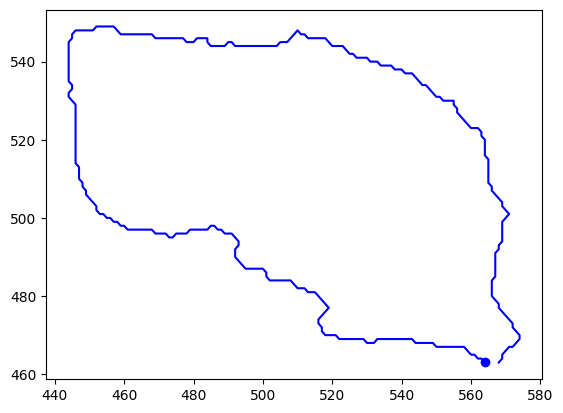

In [6]:
cell_idx = 1
plt.plot(cells[cell_idx][:, 0], cells[cell_idx][:, 1], "blue")
plt.plot(cells[cell_idx][0, 0], cells[cell_idx][0, 1], "blue", marker="o");

The size of each class is displayed below:

In [7]:
ds = {}

n_cells_arr = gs.zeros(3)


for j, line in enumerate(LINES):
    to_keep = gs.array(
        [
            one_line == line
            for one_line in lines
        ]
    )
    ds[line] = [
        cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
    ]
    nb = len(ds[line])
    print(f"{line}: {nb}")
    n_cells_arr[j] = nb

# n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
# print(n_cells_arr[1])
print({'MCF10A': n_cells_arr[0], 'MCF7': n_cells_arr[1], 'MDA_MB_231': n_cells_arr[2]})
n_cells_df = pd.DataFrame({'MCF10A': [n_cells_arr[0]], 'MCF7': [n_cells_arr[1]], 'MDA_MB_231': [n_cells_arr[2]]})

# n_cells_df = n_cells_df.set_index(LINES)
display(n_cells_df)

MCF10A: 228
MCF7: 225
MDA_MB_231: 224
{'MCF10A': 228.0, 'MCF7': 225.0, 'MDA_MB_231': 224.0}


,MCF10A,MCF7,MDA_MB_231
0,228.0,225.0,224.0


We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [8]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for line in LINES:
        output_list = []
        for one_cell in input_ds[line]:
            output_list.append(func(one_cell))
        output_ds[line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [9]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

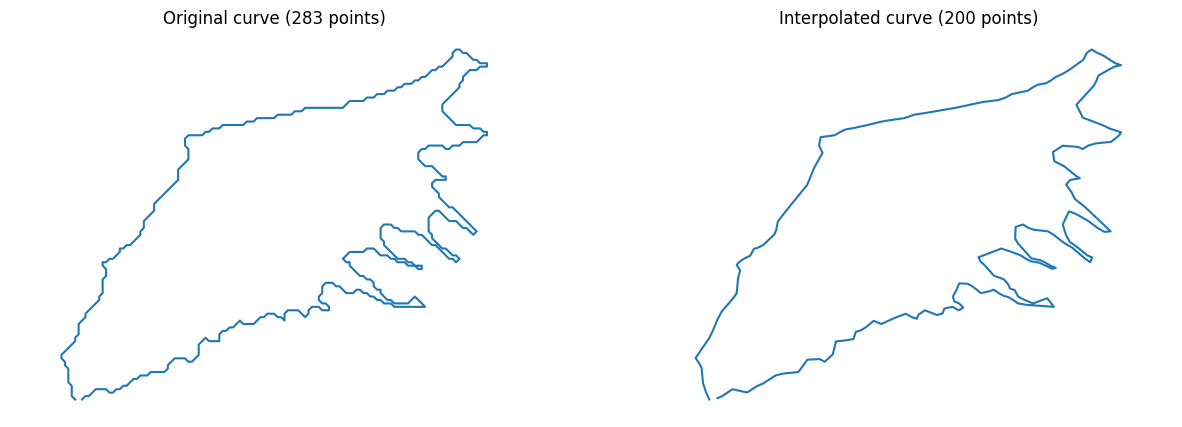

In [10]:
k_sampling_points = 200
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [11]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

For each key line, we check that the number of sampling points is the one expected, i.e. `k_sampling_points`:

In [12]:
print(ds_interp["MCF7"].shape)

(225, 200, 2)


The shape of an array of cells in `ds_interp[treatment][cell]` is therefore: `("number of cells in treatment-line", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

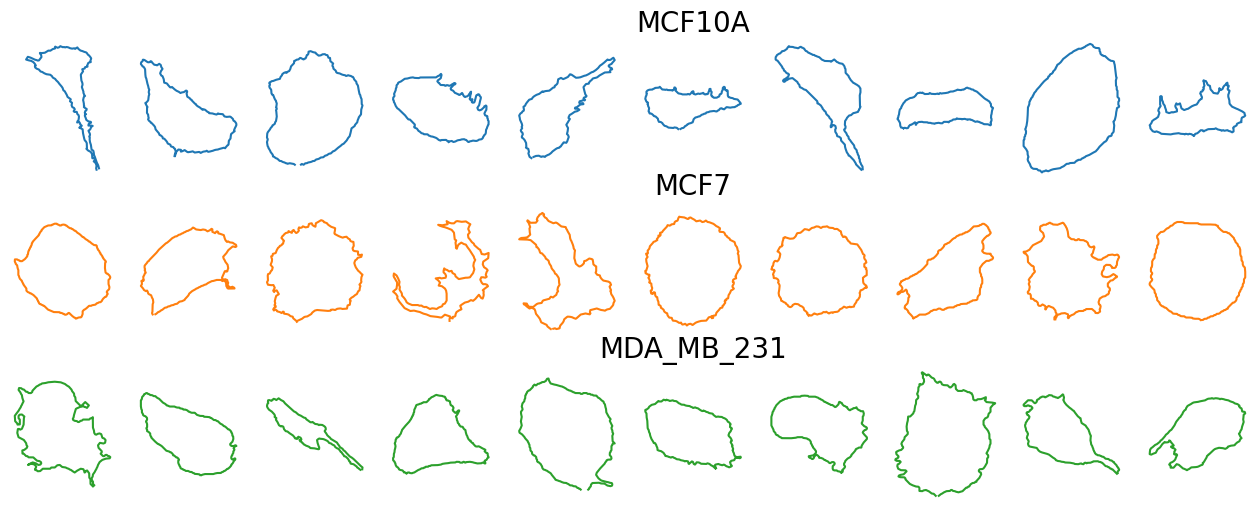

In [13]:
n_cells_to_plot = 10

fig = plt.figure(figsize=(16, 6))
count = 1
for i, line in enumerate(LINES):
    cell_data = ds_interp[line]
    for i_to_plot in range(n_cells_to_plot):
        cell = gs.random.choice(cell_data)
        fig.add_subplot(3, n_cells_to_plot, count)
        count += 1
        plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
        plt.xlim(-170, 170)
        plt.ylim(-170, 170)
        plt.axis("equal")
        plt.axis("off")
        if i_to_plot == n_cells_to_plot // 2:
            plt.title(f"{line}", fontsize=20)
plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

Visual inspection of these curves seems to indicate more protusions appearing in MDA_MB_231 cells, compared with MCF7. 

### Remove duplicate samples in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [14]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. These operations will be performed by leveraging the geometry of the so-called Kendall preshape spaces and specifically its method `PRESHAPE_SPACE.projection`, as shown below. Details on Kendall shape spaces can be found in the [module implementing them](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/pre_shape.py) or the notebooks using them. 

Additionally, since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). This exhaustive search is implemented in the function `exhaustive_align` below.

In [15]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)

PRESHAPE_SPACE.equip_with_group_action("rotations")
PRESHAPE_SPACE.equip_with_quotient_structure()


def exhaustive_align(curve, base_curve, ret_shift=False):
    """Align curve to base_curve to minimize the L² distance.

    :param bool ret_shift: return the shift of the aligned curve or not, default False

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        # Reparametrize by different start points 
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)] # Reparameterization 
        # Compute the aligned curve by this reparametrization 
        aligned = PRESHAPE_SPACE.fiber_bundle.align(point=gs.array(reparametrized), base_point=base_curve) # Rotation
        # Compute the distance between the aligned curve and base curve 
        distances[shift] = PRESHAPE_SPACE.embedding_space.metric.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    # Get the shift associated with the minimum distance between the aligned curves and base curve 
    shift_min = gs.argmin(distances)
    # Get the reparameterization associated with the minimum distance 
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    # Get the aligned curve 
    aligned_curve = PRESHAPE_SPACE.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    if ret_shift:
        return aligned_curve, shift_min
    return aligned_curve

We perform the pre-shape projection and the exhaustive alignment of the cells against the base curve, which is chosen to be the first cell curve of the dataset, called `BASE_CURVE`. 

Both the projection and the alignment make use of our auxiliary function `apply_func_to_ds`, which finally outputs a dataset of cell curves organized within a dictionnary called `ds_align`.

In [16]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

ds_proj = apply_func_to_ds(ds_proc, func= lambda x: PRESHAPE_SPACE.projection(x, rescale=False))
print(ds_proj["MCF7"].shape)

BASE_CURVE = ds_proj["MCF7"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["MCF7"].shape)

(225, 200, 2)
Shape of BASE_CURVE: (200, 2)
(225, 200, 2)


We visually evaluate that methods perform correctly, by plotting the results of the projection and the alignment through the following code.

Text(0.5, 1.0, 'Aligned curve')

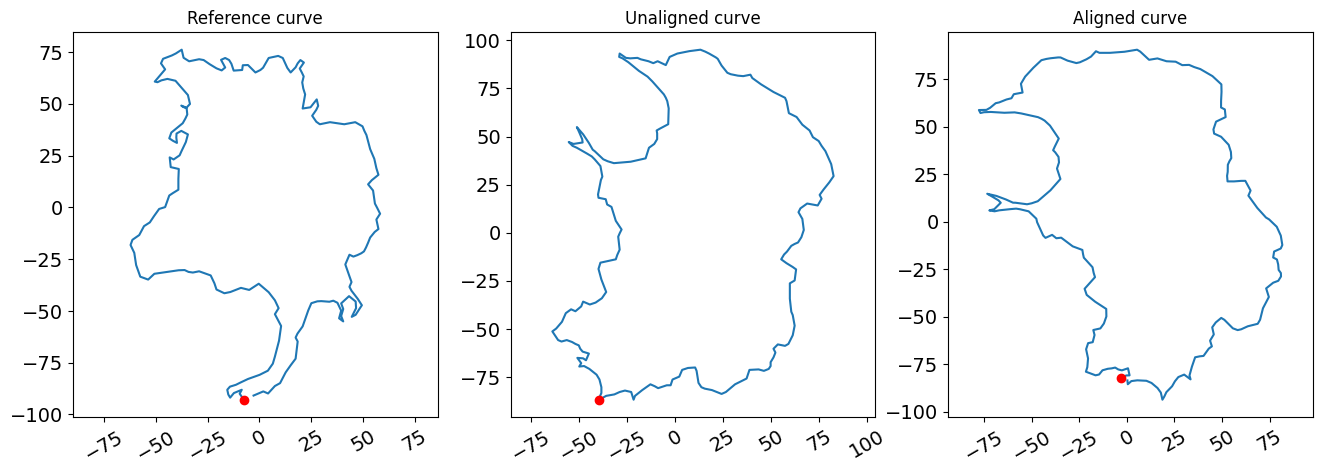

In [17]:
i_rand = gs.random.randint(n_cells_df["MCF7"])
unaligned_cell = ds_proj["MCF7"][i_rand]
aligned_cell = ds_align["MCF7"][i_rand]

fig = plt.figure(figsize=(16, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[0, :, 0], unaligned_cell[0, :, 1])
plt.plot(unaligned_cell[0, 0, 0], unaligned_cell[0, 0, 1], "ro")
plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[0, :, 0], aligned_cell[0, :, 1])
plt.plot(aligned_cell[0, 0, 0], aligned_cell[0, 0, 1], "ro")
plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)
plt.axis("equal")
plt.title("Aligned curve")

# plt.savefig(os.path.join(figs_dir, "alignment.svg"))
# plt.savefig(os.path.join(figs_dir, "alignment.pdf"))

To visually evaluate the alignment via the shift of the starting point, we have the following plots.

shift is: 171


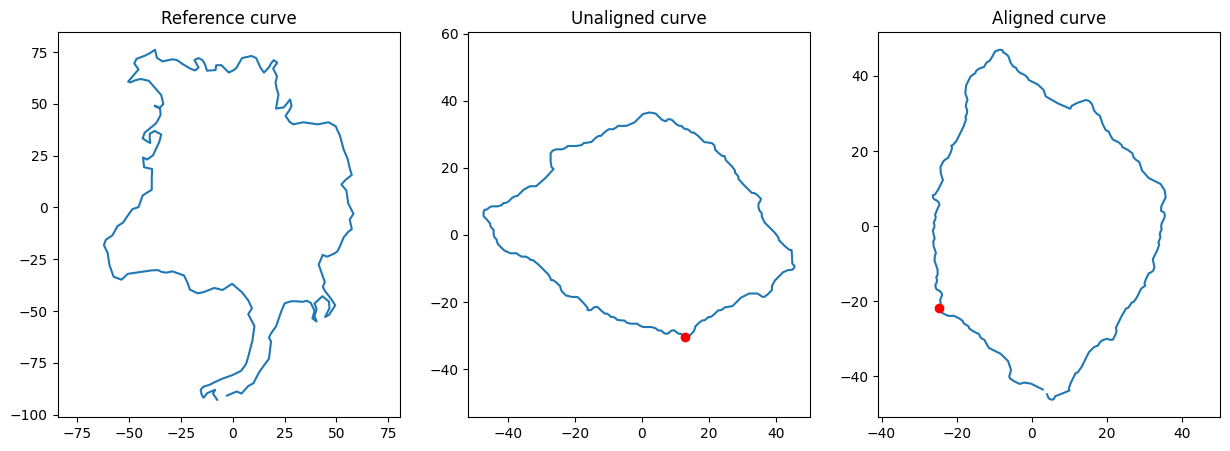

In [18]:
unaligned_curve = ds_proj["MCF7"][3]


fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
# plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_curve[:, 0], unaligned_curve[:, 1])
plt.plot(unaligned_curve[0, 0], unaligned_curve[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

aligned_curve, shift = exhaustive_align(unaligned_curve, BASE_CURVE, ret_shift=True)
print("shift is:", shift)

fig.add_subplot(133)
plt.plot(aligned_curve[:, 0], aligned_curve[:, 1])
plt.plot(aligned_curve[-shift, 0], aligned_curve[-shift, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

plt.savefig(os.path.join(figs_dir, "alignment.svg"))
plt.savefig(os.path.join(figs_dir, "alignment.pdf"))

In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data Analysis

## Compute Mean Cell Shape of the Whole Dataset: "Global" Mean Shape

We want to compute the mean cell shape of the whole dataset. Thus, we first combine all the cell shape data into a single array.

In [19]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, L2CurvesMetric


CURVES_SPACE_SRV = DiscreteCurves(Euclidean(dim=2), k_sampling_points=200)


In [20]:
cell_shapes_list = []
for line in LINES:
    cell_shapes_list.extend(ds_align[line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(677, 200, 2)


Remove outliers using DeCOr-MDS

In [21]:
from numba import jit, njit, prange
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, L2CurvesMetric

CURVES_SPACE_SRV = DiscreteCurves(Euclidean(dim=2), k_sampling_points=k_sampling_points)

def srv_dist(cell1, cell2):
    return CURVES_SPACE_SRV.metric.dist(cell1, cell2) / k_sampling_points
 
# compute pairwise distances
pairwise_srv_dists = parallel_dist(cell_shapes, srv_dist, k_sampling_points)

# run DeCOr-MDS
dim_start = 2
dim_end = 2
feature_num = 2
# outlier_indices, subspace_dim , corr_pairwise_dis, corr_coord = nsimplices(pairwise_dists, feature_num, dim_start, dim_end, std_multi=4)
# print(f"outlier_indices are: {outlier_indices}")


INFO: finding looplift candidates
/home/wanxinli/dyn/dyn/notebooks/common.py:20: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "parallel_dist" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/wanxinli/dyn/dyn/notebooks/common.py (23)

File "common.py", line 23:
def parallel_dist(cells, dist_fun, k_sampling_points):
    <source elided>
    pairwise_dists = np.zeros((cells.shape[0], cells.shape[0]))
    for i in prange(cells.shape[0]):
    ^

  @jit(nopython=False, forceobj=True)


Visualize outlier cells to check if they are artifacts 

In [22]:
# fig, axes = plt.subplots(
#     nrows= 1,
#     ncols=len(outlier_indices),
#     figsize=(2*len(outlier_indices), 2),
# )


# for i, outlier_index in enumerate(outlier_indices):
#     one_cell = cell_shapes[outlier_index]
#     ax = axes[i]
#     ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
#     ax.set_title(f"{outlier_index}", fontsize=14)
#     # ax.axis("off")
#     # Turn off tick labels
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.spines["left"].set_visible(False)

# plt.tight_layout()
# plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "outlier.svg"))

154, 357 and 606th cell look like artifacts. We decide to remove them.

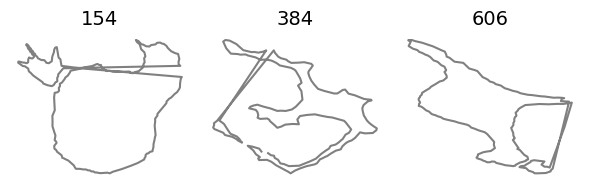

In [23]:
delete_indices = [154, 384, 606]

fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(delete_indices),
    figsize=(2*len(delete_indices), 2),
)


for i, delete_index in enumerate(delete_indices):
    one_cell = cell_shapes[delete_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"gray")
    ax.set_title(f"{delete_index}", fontsize=14)
    # ax.axis("off")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, "delete_outlier.svg"))
plt.savefig(os.path.join(figs_dir, "delete_outlier.pdf"))

In [24]:
# Remove the cells from cells, cell_shapes,  lines and ds_align
cells, cell_shapes, lines, ds_proc, ds_proj, ds_align \
    = remove_cells_one_layer(cells, cell_shapes, lines, ds_proc, ds_proj, ds_align, delete_indices)

Calculate the perimeters for all cells 

In [25]:
def calc_perimeter(point):
    total_space_metric = PRESHAPE_SPACE._get_total_space_metric()
    centered_point = PRESHAPE_SPACE.center(point)
    frob_norm = total_space_metric.norm(centered_point)
    return frob_norm

In [26]:
ds_perimeter = apply_func_to_ds(ds_proc, func= lambda x: calc_perimeter(x))

After the removal of outliers, we have

In [27]:
print(f'Number of cells: {len(cells)}, Number of lines: {len(lines)}, Shape of cell_shapes: {cell_shapes.shape}')
for line, line_cells in ds_align.items():
    print(f"Cell line {line}: {len(line_cells)}")

Number of cells: 674, Number of lines: 674, Shape of cell_shapes: (674, 200, 2)
Cell line MCF10A: 227
Cell line MCF7: 224
Cell line MDA_MB_231: 223


We compute the mean cell shape by using the SRV metric defined on the space of curves' shapes. The space of curves' shape is a manifold: we use the Frechet mean, associated to the SRV metric, to get the mean cell shape.

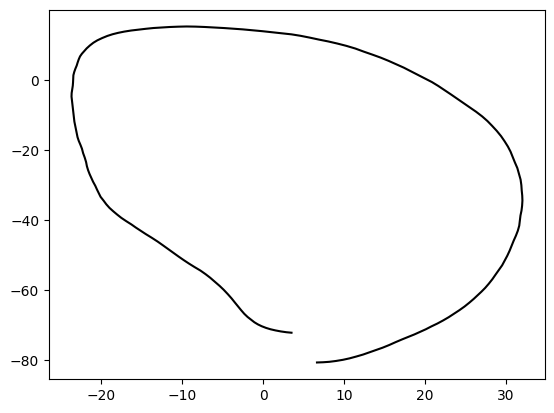

In [28]:
from geomstats.learning.frechet_mean import FrechetMean

mean = FrechetMean(space=CURVES_SPACE_SRV)
mean.fit(cell_shapes)

mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black");

The mean cell shape does indeed look like a cell shape. We note that there is a discontinuity in the cell because we have modeled the curves' boundaries as open curves. The space of curves considered here is also the space of (open) discrete curves.

Unfortunately, sometimes there could be Nans in the values of the mean shape. If this is the case, this code removes them manually, and re-interpolate the mean shape.

In [29]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = interpolate(mean_estimate_clean, k_sampling_points)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(200, 2)
0
(200, 2)


We plot the mean cell shape, superimposed on top of the dataset of cells (displayed in light grey underneath).

(674, 200, 2)


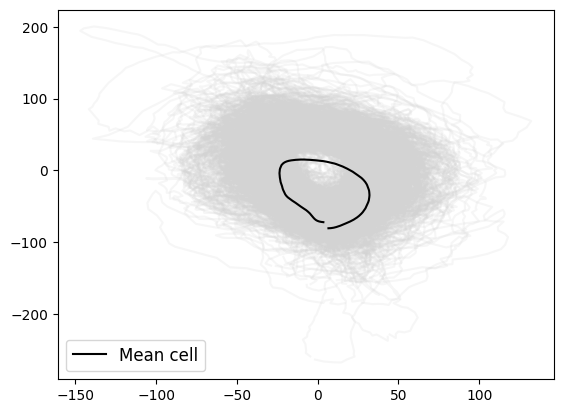

In [30]:
print(cell_shapes.shape)
for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_clean[:, 0], mean_estimate_clean[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We see that the scale and alignment of the mean shape is slightly off. This makes sense, as our computations have quotiented out scale and alignment. We correct it manually.

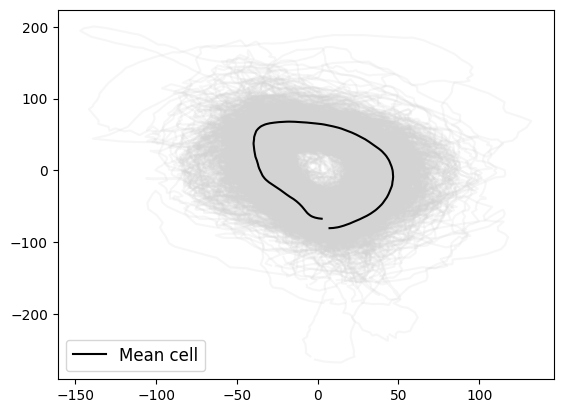

In [31]:
mean_estimate_aligned = 1.55 * (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We visualize the same plot, but now:
- closing the mean shape that becomes a closed curve
- plotting underneath the mean shape the distribution of the sampling points of all the curves of the dataset, through a kernel density estimation.

Visualizing the full datasets of 640+ cells takes a long time. Therefore, we also select only 200 cells, randomly, within the dataset.

In [32]:
mean_estimate_aligned_bis = gs.vstack(
    [mean_estimate_aligned[4:], mean_estimate_aligned[-1]]
)

Text(0.5, 1.0, 'Global mean shape superimposed on the\n dataset of cells')

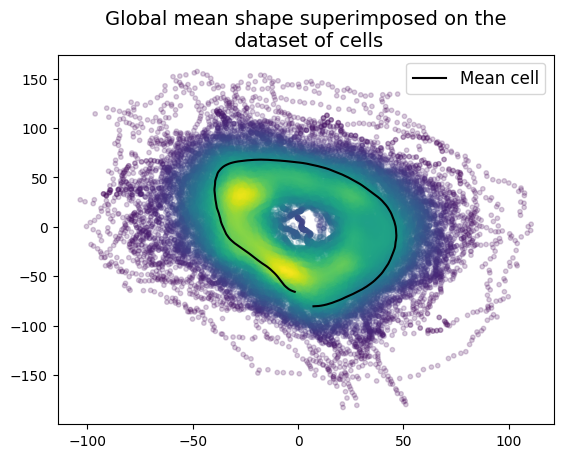

In [33]:
from scipy.stats import gaussian_kde

cells_to_plot = cell_shapes[gs.random.randint(len(cell_shapes), size=200)]
points_to_plot = cells_to_plot.reshape(-1, 2)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
plt.plot(
    mean_estimate_aligned_bis[:, 0],
    mean_estimate_aligned_bis[:, 1],
    "black",
    label="Mean cell",
)
plt.legend(fontsize=12)
plt.title("Global mean shape superimposed on the\n dataset of cells", fontsize=14)

# plt.savefig("global_mean_shape.svg")

This plot allows to verify that the mean shape that has been computed makes sense.

Also we compute the linear mean

0
(200, 2)
0
(200, 2)


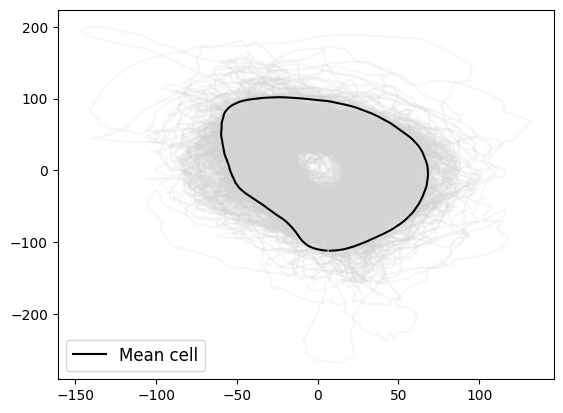

In [34]:
linear_mean_estimate = gs.mean(cell_shapes, axis=0)
print(gs.sum(gs.isnan(linear_mean_estimate)))
linear_mean_estimate_clean = linear_mean_estimate[~gs.isnan(gs.sum(linear_mean_estimate, axis=1)), :]
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_clean = interpolate(linear_mean_estimate_clean, k_sampling_points)

print(gs.sum(gs.isnan(linear_mean_estimate_clean)))
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_aligned = 1.55 * (
    linear_mean_estimate_clean - gs.mean(linear_mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    linear_mean_estimate_aligned[:, 0], linear_mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

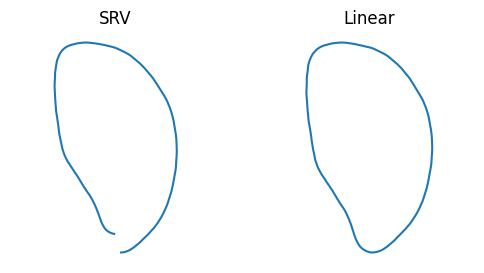

In [35]:
fig = plt.figure(figsize=(6, 3))

fig.add_subplot(121)
plt.plot(mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1])
plt.axis("equal")
plt.title("SRV")
plt.axis("off")

fig.add_subplot(122)
plt.plot(linear_mean_estimate_aligned[:, 0], linear_mean_estimate_aligned[:, 1])
plt.axis("equal")
plt.title("Linear")
plt.axis("off")

plt.savefig(os.path.join(figs_dir, "global_mean.svg"))
plt.savefig(os.path.join(figs_dir, "global_mean.pdf"))


Not sure how but the 1.55 makes the seperation of the histogram better, though it does not look like the mean of the cell shapes.

# Analyze Distances to the "Global"  Mean Shape

We consider each of the subgroups of cells, defined by their  cell line. We wish to study how far each of this group is from the global mean shape. We compute the list of distances to the global mean shape.

In [36]:
dists_to_global_mean = {}
metric = 'SRV'
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align, func=lambda x: CURVES_SPACE_SRV.metric.dist(x, mean_estimate_aligned)
)

dists_to_global_mean_list = {}
dists_to_global_mean_list[metric] = []
for l in LINES:
    dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][l])

We plot the distances to the mean global shape, by splitting them into the three cell lines.

In [37]:
from scipy import stats

Plot three groups separately 

Text(0.5, 0.98, 'Histograms of SRV distances to global mean cell')

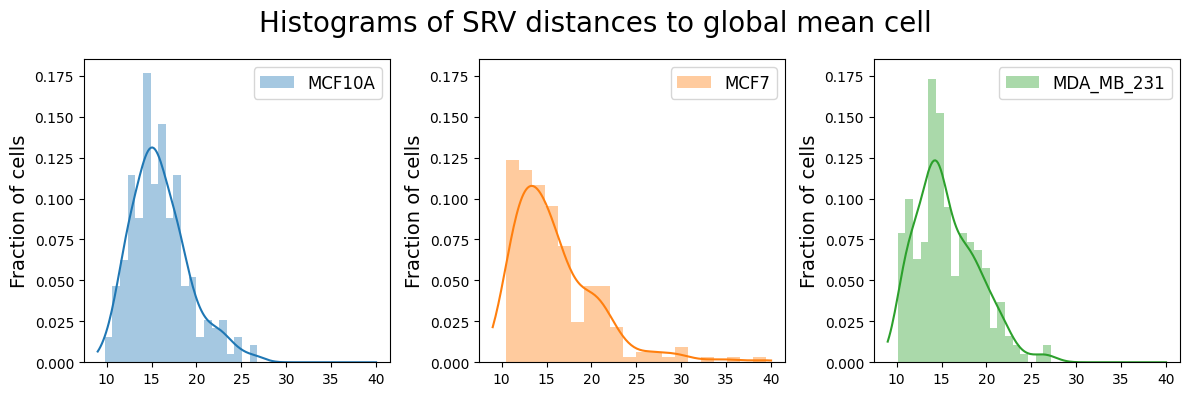

In [38]:
fig, axs = plt.subplots(1, len(LINES), sharex=True, sharey=True, tight_layout=True, figsize=(12, 4))
hists = []

min_dists = min(dists_to_global_mean_list[metric])
max_dists = max(dists_to_global_mean_list[metric])
xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)

for j, line in enumerate(LINES):

    axs[j].yaxis.set_tick_params(labelleft=True)

    distances = dists_to_global_mean[metric][line][
        ~gs.isnan(dists_to_global_mean[metric][line])
    ]
    color = f"C{j}"
    hist, _, _ = axs[j].hist(
        distances, bins=20, alpha=0.4, density=True, color=color, label=line
    )
    
    hists.append(hist)

    kde = stats.gaussian_kde(distances)
    axs[j].plot(xx, kde(xx), color=color)

    axs[j].set_ylabel("Fraction of cells", fontsize=14)
    axs[j].legend(fontsize=12)


fig.suptitle("Histograms of SRV distances to global mean cell", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "SRV_histogram.svg"))
# plt.savefig(os.path.join(figs_dir, "SRV_histogram.pdf"))



Caculate KL distance between every pair of histograms 

In [39]:
print(f"For {metric}")
for i in range(len(LINES)):
    for j in range(i+1, len(LINES)):
        distance = wasserstein_distance(hists[i], hists[j])
        print(f"distance between {LINES[i]} and {LINES[j]} is {round(distance, 2)}")

For SRV
distance between MCF10A and MCF7 is 0.02
distance between MCF10A and MDA_MB_231 is 0.01
distance between MCF7 and MDA_MB_231 is 0.02


Compute distances to linear mean

In [40]:
metric = 'Linear'
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align, func=lambda x: gs.linalg.norm(linear_mean_estimate_aligned - x) 
)

dists_to_global_mean_list[metric] = []
for l in LINES:
    dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][l])

In [41]:
print(f"For {metric}")
for i in range(len(LINES)):
    for j in range(i+1, len(LINES)):
        distance = wasserstein_distance(hists[i], hists[j])
        print(f"distance between {LINES[i]} and {LINES[j]} is {round(distance, 2)}")

For Linear
distance between MCF10A and MCF7 is 0.02
distance between MCF10A and MDA_MB_231 is 0.01
distance between MCF7 and MDA_MB_231 is 0.02


Plot the three groups separately

Text(0.5, 0.98, 'Histograms of linear distances to global mean cell')

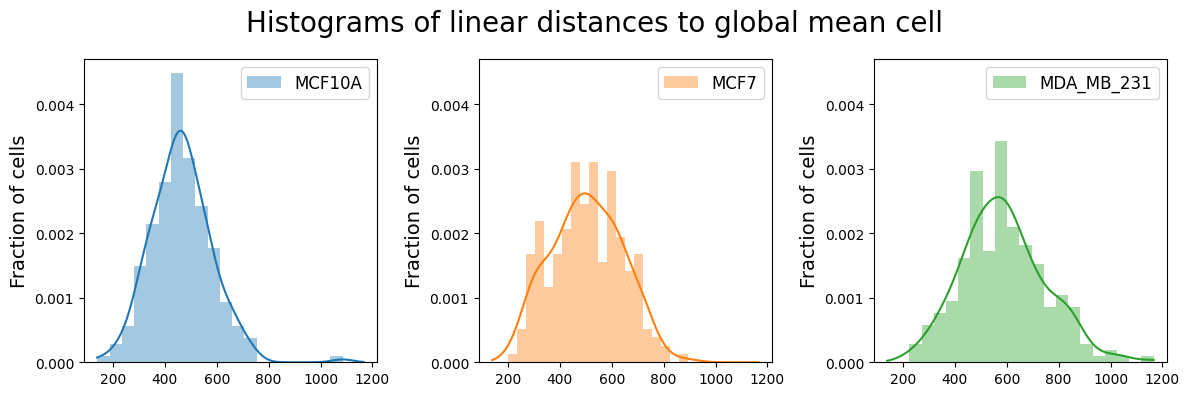

In [42]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, tight_layout=True, figsize=(12, 4))

for j, line in enumerate(LINES):
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)

    axs[j].yaxis.set_tick_params(labelleft=True)
    distances = dists_to_global_mean[metric][line][
        ~gs.isnan(dists_to_global_mean[metric][line])
    ]
    color = f"C{j}"
    axs[j].hist(
        distances, bins=20, alpha=0.4, density=True, color=color, label=line
    )
    kde = stats.gaussian_kde(distances)
    axs[j].plot(xx, kde(xx), color=color)

    axs[j].set_ylabel("Fraction of cells", fontsize=14)
    axs[j].legend(fontsize=12)

fig.suptitle("Histograms of linear distances to global mean cell", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "linear_histogram.svg"))
# plt.savefig(os.path.join(figs_dir, "linear_histogram.pdf"))


Put distances to the global mean using SRV and Linear distance together

SRV MCF10A
SRV MCF7
SRV MDA_MB_231
Linear MCF10A
Linear MCF7
Linear MDA_MB_231


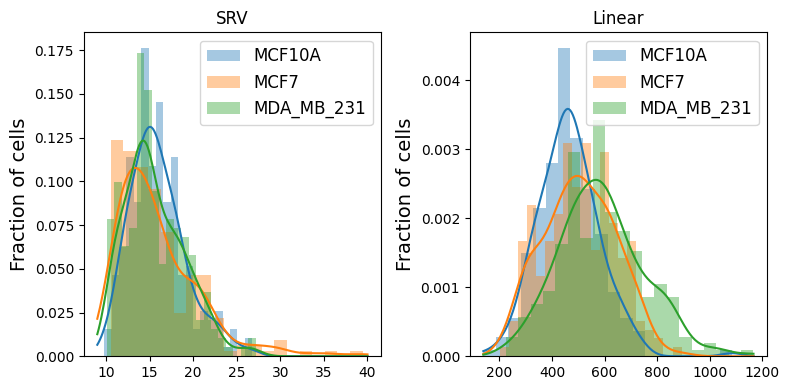

In [43]:
fig, axs = plt.subplots(1, len(METRICS), sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

for i, metric in enumerate(METRICS):
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)
    
    for j, line in enumerate(LINES):
        distances = dists_to_global_mean[metric][line][
            ~gs.isnan(dists_to_global_mean[metric][line])
        ]
        color = f"C{j}"
        counts, bin_edges, _  = axs[i].hist(
            distances, bins=20, alpha=0.4, density=True, color=color, label=line
        )
        print(metric, line)
        kde = stats.gaussian_kde(distances)
        print(kde)
        axs[i].plot(xx, kde(xx), color=f"C{j}")

    # axs[i].set_xlim(0.25, 1.25)
    axs[i].set_title(f"{metric}")
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

# fig.suptitle("Fig 1: Distances to the global mean")
plt.savefig(os.path.join(figs_dir, f"histogram_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"histogram_{suffix}.pdf"))
plt.show()


In [44]:
# line = 'MCF7'
# metric = 'SRV'
# distances = dists_to_global_mean[metric][line]
# print(min(distances), max(distances))
# group_1_left = 0.45048555
# group_1_right = 0.48449343
# group_2_left = 0.89258795
# group_2_right = 0.92659583
# group_1_indices = [i for i, element in enumerate(distances) if element <= group_1_right and element > group_1_left]
# print(group_1_indices)
# group_2_indices = [i for i, element in enumerate(distances) if element <= group_2_right and element > group_2_left]
# print(group_2_indices)
# group_1_cells = ds_align[line][group_1_indices,:,:]
# group_2_cells = ds_align[line][group_2_indices,:,:]

# fig = plt.figure(figsize=(2*len(group_1_indices), 2))
# count = 1
# for index in range(len(group_1_indices)):
#     cell = group_1_cells[index]
#     fig.add_subplot(2, len(group_1_indices), count)
#     count += 1
#     plt.plot(cell[:, 0], cell[:, 1])
#     plt.axis("equal")
#     plt.axis("off")

# for index in range(len(group_2_indices)):
#     cell = group_2_cells[index]
#     fig.add_subplot(2, len(group_1_indices), count)
#     count += 1
#     plt.plot(cell[:, 0], cell[:, 1])
#     plt.axis("equal")
#     plt.axis("off")

# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal.svg"))
# plt.savefig(os.path.join(figs_dir, f"{line}_bimodal.pdf"))

We want to test the separation of different groups.

In [45]:
dists_to_global_mean['Linear']['MCF7'][
                ~gs.isnan(dists_to_global_mean[metric]['MCF7'])
            ]

array([351.0370086 , 532.67441612, 662.7735446 , 718.52594652,
       324.69219549, 525.69888798, 594.85196188, 360.7156818 ,
       280.81489229, 585.58552744, 564.65247866, 550.4233504 ,
       758.68112134, 618.19899238, 425.58235175, 412.72344075,
       509.07470576, 272.91453013, 444.88542063, 422.56376367,
       519.58982599, 391.71958415, 601.48347517, 474.70864327,
       447.61072962, 423.49618494, 584.10938847, 420.79310791,
       330.47316517, 626.79782742, 311.32212787, 456.95857203,
       475.05671294, 494.53559486, 315.10585477, 442.40538499,
       333.90869569, 391.9426664 , 515.38398598, 516.43106213,
       426.31533469, 475.22776724, 450.68649279, 492.43809293,
       425.55760669, 390.92169343, 650.08703886, 456.41274427,
       469.07195895, 235.59043901, 493.77965979, 287.14954929,
       759.01260624, 458.69217335, 455.4742016 , 616.89054773,
       283.77361954, 485.00814716, 307.10638735, 760.59825625,
       821.24114087, 607.88393207, 389.28001171, 570.82

In [46]:
import scipy.stats as stats

for metric in METRICS:
    for i in range(len(LINES)):
        for j in range(i+1, len(LINES)):
            line_1 = LINES[i]
            line_2 = LINES[j]
            print(line_1, line_2, metric)
            distances_1 = dists_to_global_mean[metric][line_1][
                ~gs.isnan(dists_to_global_mean[metric][line_1])]
   
            distances_2 = dists_to_global_mean[metric][line_2][
                ~gs.isnan(dists_to_global_mean[metric][line_2])]
            t_statistic, p_value = stats.ttest_ind(distances_1, distances_2)
            print(f"Significance of differences between {line_1} and {line_2} using {metric} metric is: {p_value}")


MCF10A MCF7 SRV
Significance of differences between MCF10A and MCF7 using SRV metric is: 0.9303382544802882
MCF10A MDA_MB_231 SRV
Significance of differences between MCF10A and MDA_MB_231 using SRV metric is: 0.2695264748633994
MCF7 MDA_MB_231 SRV
Significance of differences between MCF7 and MDA_MB_231 using SRV metric is: 0.33267632199659436
MCF10A MCF7 Linear
Significance of differences between MCF10A and MCF7 using Linear metric is: 0.0008619557415114085
MCF10A MDA_MB_231 Linear
Significance of differences between MCF10A and MDA_MB_231 using Linear metric is: 1.63430611854166e-19
MCF7 MDA_MB_231 Linear
Significance of differences between MCF7 and MDA_MB_231 using Linear metric is: 2.929054843843583e-09


Assess the correlation between distances to the global mean and cell perimeters

The Pearson coefficient between distances and perimeters is 0.51


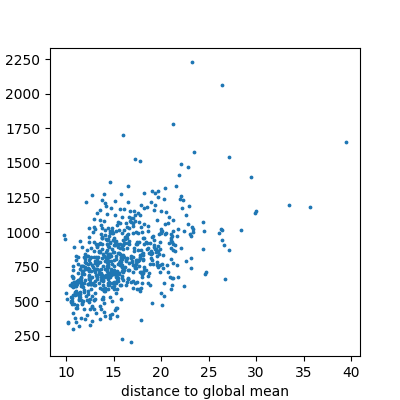

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

In [82]:
all_distances = []
all_perimeters = []

plt.figure(figsize=(4,4))

for line in LINES:
    distances = dists_to_global_mean['SRV'][line]
    perimeters = ds_perimeter[line]
    all_distances.extend(distances)
    all_perimeters.extend(perimeters)
    plt.scatter(distances, perimeters, s=3, c='tab:blue')

plt.xlabel("distance to global mean")
plt.ylabel("perimeter")

coef, _ = pearsonr(all_distances, all_perimeters)

print(f"The Pearson coefficient between distances and perimeters is {round(coef, 2)}")
plt.savefig(os.path.join(figs_dir, f"global_distance_perimeter.svg"))
plt.savefig(os.path.join(figs_dir, f"global_distance_perimeter.pdf"))

We observe when using the SRV metric, cells of different cell lines are better separated.

# Visualization of the Mean of each Cell Line

The mean distances to the global mean shape differ. We also plot the mean shape for each of the subgroup, to get intuition on how the mean shape of each subgroup looks like.

We calculate SRV mean

In [47]:
mean_line_cells = {}
metric = 'SRV'
mean_line_cells[metric] = {}
for line in LINES:
    line_cells = []
    line_cells.extend(ds_align[line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(gs.array(line_cells[:225]))
    mean_line_cells[metric][line] = mean_estimator.estimate_

We then calculate linear mean.

In [48]:
metric = 'Linear'
mean_line_cells[metric] = {}
for line in LINES:
    mean_line_cells[metric][line] = gs.mean(ds_align[line], axis=0)

While the mean shapes of the control groups (for both cell lines) look regular, we observe that:
- the mean shape for cytd is the most irregular (for both cell lines)
- while the mean shape for jasp is more elongated for dlm8 cell line, and more irregular for dunn cell line.

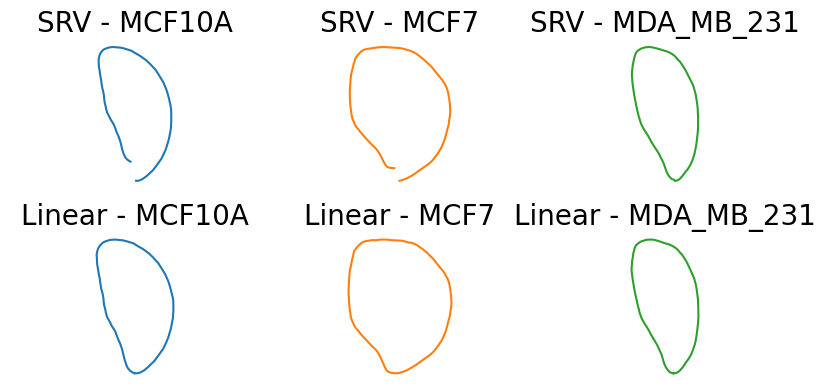

In [49]:
fig, axes = plt.subplots(
    nrows= len(METRICS),
    ncols= len(LINES),
    figsize=(2.7 * len(LINES), 2 * len(METRICS)),
)

for i, metric in enumerate(METRICS):
    for j, line in enumerate(LINES):
        ax = axes[i, j]
        mean_cell = mean_line_cells[metric][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C"+str(j))
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(f"{metric} - {line}", fontsize=20)
plt.tight_layout()
# plt.suptitle(f"Quantiles for SRV metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, "own_mean.svg"))
plt.savefig(os.path.join(figs_dir, "own_mean.pdf"))

# Distance of the Cell Shapes to their Own Mean Shape

Lastly, we evaluate how each subgroup of cell shapes is distributed around the mean shape of their specific subgroup.

In [50]:
dists_to_own_mean = {}
nan_ids = {}
metric = 'SRV'
dists_to_own_mean[metric] = {}
for line in LINES:
    dists = []
    ids = []
    for i_curve, curve in enumerate(ds_align[line]):
        one_dist = CURVES_SPACE_SRV.metric.dist(curve, mean_line_cells[metric][line])
        if ~gs.isnan(one_dist):
            dists.append(one_dist)
        else:
            ids.append(i_curve)
    dists_to_own_mean[metric][line] = dists
    nan_ids[line] = ids

The above code find a given number of quantiles within the distance's histogram, using SRV metric and own mean, and plots the corresponding cell, for each cell line.

We observe as quantiles go up, more irregularies present.

In [51]:
metric = 'Linear'
dists_to_own_mean[metric] = {}
nan_ids = {}
for line in LINES:
    dists = []
    ids = []
    for i_curve, curve in enumerate(ds_align[line]):
        one_dist = gs.linalg.norm(curve-mean_line_cells[metric][line])
        # gs.linalg.norm(linear_mean_estimate - x) 
        if ~gs.isnan(one_dist):
            dists.append(one_dist)
        else:
            ids.append(i_curve)
    dists_to_own_mean[metric][line] = dists
    nan_ids[line] = ids

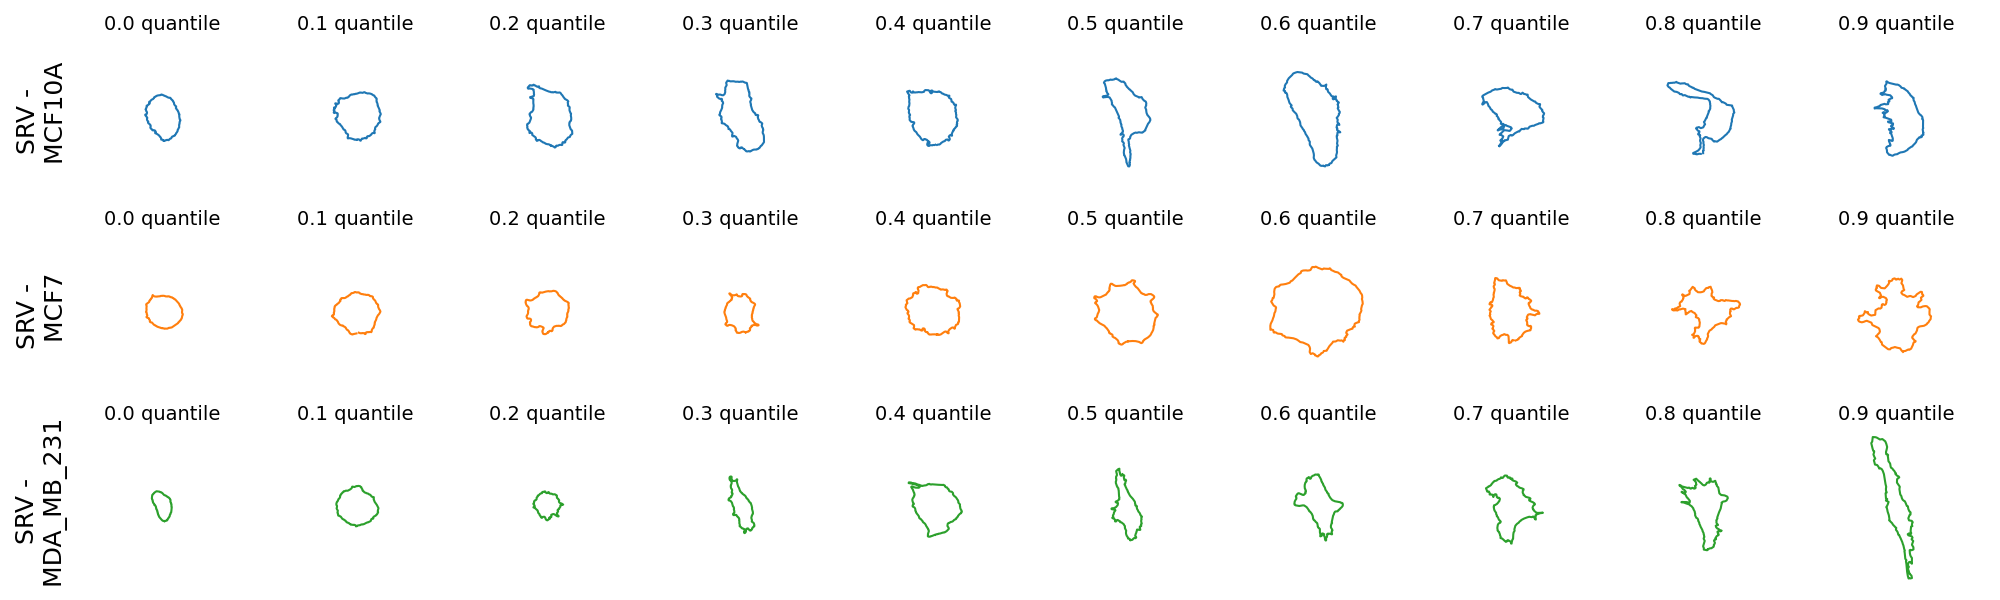

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

In [94]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows= len(LINES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(LINES)),
)

for i, line in enumerate(LINES):
    metric = 'SRV'
    dists_list = dists_to_own_mean[metric][line]
    dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
    cells_list = list(ds_align[line])
    assert len(dists_list) == len(dists_list)
    n_cells = len(dists_list)

    zipped_lists = zip(dists_list, cells_list)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
    for i_quantile in range(n_quantiles):
        quantile = int(0.1 * n_cells * i_quantile)
        one_cell = sorted_cells_list[quantile]
        ax = axes[i, i_quantile]
        ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
        ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
        ax.set_xlim(-170, 170)
        ax.set_ylim(-170, 170)
        # ax.axis("off")
        # Turn off tick labels
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        
        if i_quantile == 0:
            ax.set_ylabel(f"{metric} - \n {line}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"quantile_{suffix}.svg"))
plt.savefig(os.path.join(figs_dir, f"quantile_{suffix}.pdf"))

The above code find a given number of quantiles within the distance's histogram, using linear metric and own mean, and plots the corresponding cell, for each cell line.

In comparison to using the SRV metric, we observe there exists more irregular cells in the lower quantiles.

Assess the correlation between own distances and cell perimeters. 

Since we consider the its category's own means rather than the global mean, we plot the correlation plot for each catogory separately. 

The Pearson coefficient between distances and perimeters for MCF10A is 0.37
The Pearson coefficient between distances and perimeters for MCF7 is 0.68
The Pearson coefficient between distances and perimeters for MDA_MB_231 is 0.74


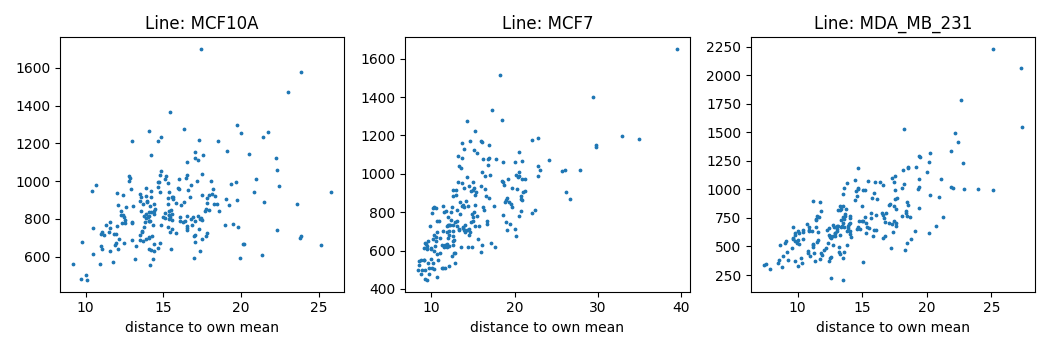

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

In [92]:
fig, axs = plt.subplots(1,len(LINES))
fig.set_figwidth(3.5*len(LINES))
fig.set_figheight(3.5)

for i, line in enumerate(LINES):

    axs[i].set_title(f'Line: {line}')    
    distances = dists_to_own_mean['SRV'][line]
    perimeters = ds_perimeter[line]
    axs[i].scatter(distances, perimeters, s=3)
    axs[i].set_xlabel("distance to own mean")

    coef, _ = pearsonr(distances, perimeters)
    print(f"The Pearson coefficient between distances and perimeters for {line} is {round(coef, 2)}")

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"own_distance_perimeter.svg"), bbox_inches='tight')
plt.savefig(os.path.join(figs_dir, f"own_distance_perimeter.pdf"), bbox_inches='tight')

# Dimensionality Reduction

We use the following experiments to illustrate how SRV metric can help with dimensionality reduction 

In [53]:
sys.path.append("/home/wanxinli/dyn/dyn/datasets")
from experimental import *
cells_new = preprocess_cells(cells, len(cells), k_sampling_points)

... Selecting only a random subset of 674 / 674 cells.
... Interpolating: Cell boundaries have 200 samplings points.
... Removing potential duplicate sampling points on cell boundaries.

- Cells: quotienting translation.


In [54]:
pairwise_srv_dists = parallel_dist(cells_new, srv_dist, k_sampling_points)

Calculate MDS statistics for dimension 2

In [55]:
from sklearn import manifold


mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_srv_dists).embedding_
print("the stress for SRV model is:", mds.stress_)
print(pairwise_srv_dists.shape)
print(pos.shape)

the stress for SRV model is: 0.012151218325877771
(674, 674)
(674, 2)


MDS embedding of  different cell lines 

In [56]:
embs = {}
index = 0

for line in LINES:
    cell_num = len(ds_align[line])   
    embs[line] = pos[index:index+cell_num]
    index += cell_num

We draw a comparison with linear metric using the following code

In [57]:
def linear_dist(cell1, cell2):
    return gs.linalg.norm(cell1 - cell2) / k_sampling_points

In [58]:
pairwise_linear_dists = parallel_dist(cells_new, linear_dist, k_sampling_points)

In [59]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
linear_pos = mds.fit(pairwise_linear_dists).embedding_
print("the stress for linear model is:", mds.stress_)


the stress for linear model is: 2.154248419350185


The stress for MDS embedding using the linear metric is better than SRV metric. 

However, if we can make a better interpretation of the visual result of SRV metric, we could still argue SRV is better at capturing cell heterogeneity. 

In [60]:
linear_embs = {}
index = 0
for line in LINES:
    cell_num = len(ds_align[line])   
    linear_embs[line] = linear_pos[index:index+cell_num]
    index += cell_num

Plot SRV and linear metric dimension reduction side by side

Text(0.5, 0.98, 'MDS of cell shapes in 2D for breast cancer dataset')

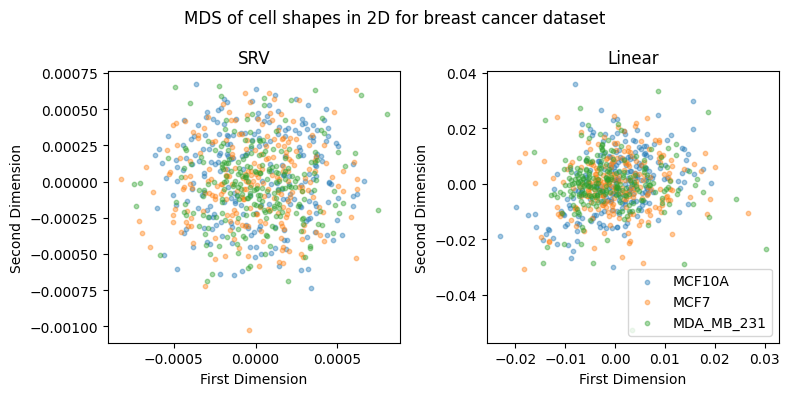

In [61]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

for j, line in enumerate(LINES):
    cur_embs = embs[line]
    axs[0].scatter(
            cur_embs[:, 0],
            cur_embs[:, 1],
            s=10,
            alpha=0.4,
            label=line
        )
    # axs.set_xlim(-3.5*1e-5, 3*1e-5)
    axs[0].set_xlabel("First Dimension")
    axs[0].set_ylabel("Second Dimension")
    # axs[0].legend()
    axs[0].set_title("SRV")

for j, line in enumerate(LINES):
    cur_embs = linear_embs[line]
    axs[1].scatter(
            cur_embs[:, 0],
            cur_embs[:, 1],
            label=line,
            alpha=0.4,
            s=10
        )
    # axs.set_xlim(-3*1e-5, 3.5*1e-5)
    axs[1].set_xlabel("First Dimension")
    axs[1].set_ylabel("Second Dimension")
    axs[1].legend()
    axs[1].set_title("Linear")

fig.suptitle("MDS of cell shapes in 2D for breast cancer dataset")


We observe that when it comes to dimension reduction, using SRV metric does not separate different cell lines better than using the linear metric.

We also consider embedding in 3D. 

In [62]:
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_srv_dists).embedding_
print("the stress for SRV model is:", mds.stress_)
print(pairwise_srv_dists.shape)
print(pos.shape)

the stress for SRV model is: 0.008014315350186268
(674, 674)
(674, 3)


In [63]:
embs = {}
index = 0
for line in LINES:
    cell_num = len(ds_align[line])   
    embs[line] = pos[index:index+cell_num]
    index += cell_num

In [64]:
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
linear_pos = mds.fit(pairwise_linear_dists).embedding_
print("the stress for linear model is:", mds.stress_)


the stress for linear model is: 1.0336442970416517


In [65]:
linear_embs = {}
index = 0
for line in LINES:
    cell_num = len(ds_align[line])   
    linear_embs[line] = linear_pos[index:index+cell_num]
    index += cell_num

In [66]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

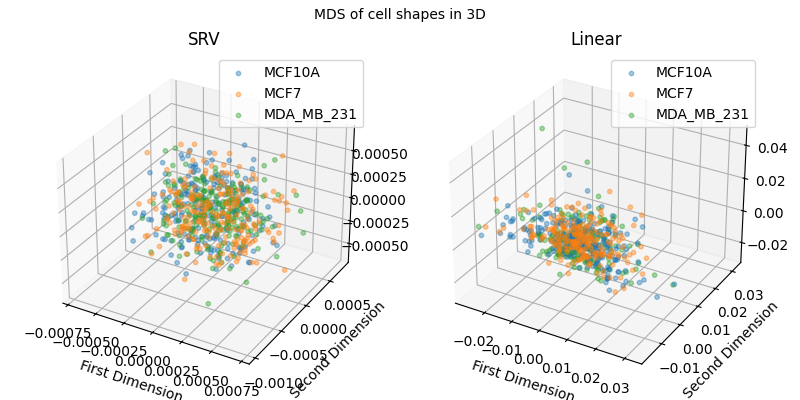

In [67]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

for j, line in enumerate(LINES):
    distances = []
    cur_embs = embs[line]
    axs[0].scatter(
            cur_embs[:, 0],
            cur_embs[:, 1],
            cur_embs[:, 2],
            label=line,
            alpha=0.4,
            s=10
        )
    # axs[j].set_xlim(-3*1e-5, 3.5*1e-5)
    axs[0].set_xlabel("First Dimension")
    axs[0].set_ylabel("Second Dimension")
    axs[0].legend()
    axs[0].set_title(f"SRV")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=10)


for j, line in enumerate(LINES):
    distances = []
    cur_embs = linear_embs[line]
    axs[1].scatter(
            cur_embs[:, 0],
            cur_embs[:, 1],
            cur_embs[:, 2],
            alpha=0.4,
            label=line,
            s=10
        )
    # axs[j].set_xlim(-3*1e-5, 3.5*1e-5)
    axs[1].set_xlabel("First Dimension")
    axs[1].set_ylabel("Second Dimension")
    axs[1].legend()
    axs[1].set_title(f"Linear")
fig.suptitle("MDS of cell shapes in 3D", fontsize=10)

plt.tight_layout()
# plt.show()

MDS embedding does notl work well using either SRV metric or linear metric. Let us try PCA.

In [68]:
from sklearn.decomposition import PCA
from geomstats.learning.pca import TangentPCA

In [69]:
dists_summary = pd.DataFrame(
    data={
        "lines": lines
        # "Linear": dists["Linear"],
        # "SRV": dists["SRV"],
    }
)

In [70]:
cells_flat = gs.reshape(cell_shapes, (len(cells), -1))
print(cell_shapes.shape)
print(cells_flat.shape)

(674, 200, 2)
(674, 400)


In [71]:
n_components = 10

pcas = {}
pcas["Linear"] = PCA(n_components=n_components).fit(cells_flat)
pcas["SRV"] = TangentPCA(n_components=n_components, space=CURVES_SPACE_SRV).fit(cell_shapes)

In [72]:
cell_transformed = {}
cell_transformed["Linear"] = pcas["Linear"].fit_transform(cells_flat)
cell_transformed["SRV"] = pcas["SRV"].fit_transform(cell_shapes)

In [73]:
lines_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(lines))}
lines_name = "lines"

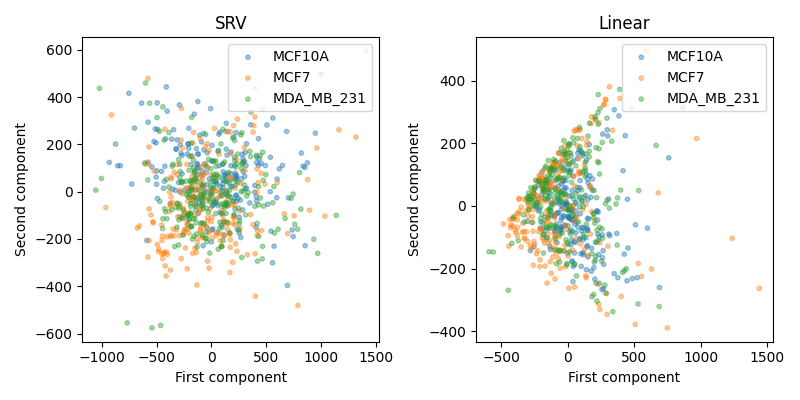

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i, metric_name in enumerate(["SRV", "Linear"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [lines_dict], [lines], [lines_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label,
                s=10
            )
            axs[i].set_xlabel("First component")
            axs[i].set_ylabel("Second component")
            # axs[i].set_xlim(-1, 1.5)
            # axs[i].set_ylim(-0.4, 0.9)
            axs[i].set_title(metric_name)
            axs[i].legend()
# plt.suptitle("Fig 6: PCA of cell shapes in 2D")
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "PCA_2D.svg"))
plt.savefig(os.path.join(figs_dir, "PCA_2D.pdf"))


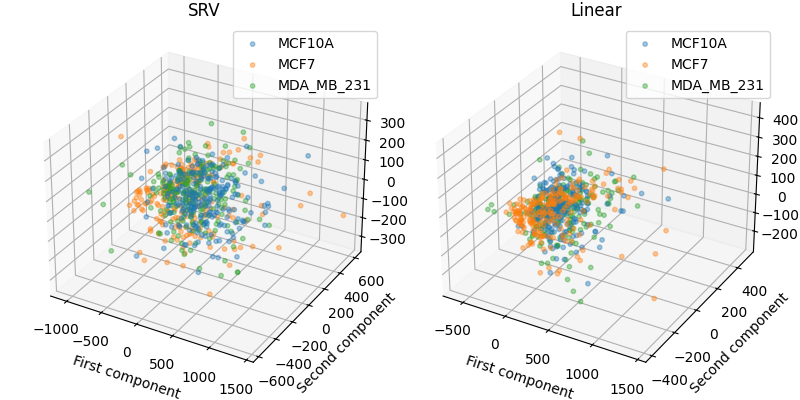

In [75]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

for i, metric_name in enumerate(["SRV", "Linear"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [lines_dict], [lines], [lines_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                cell_tr[:, 2],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label,
                s=10
            )
            # axs[i].set_xlim(-1, 1.5)
            # axs[i].set_ylim(-0.4, 0.9)
            # axs[i].set_zlim(-0.4, 0.7)
            axs[i].set_xlabel("First component")
            axs[i].set_ylabel("Second component")
            # axs[i].set_zlabel("Third component")
            axs[i].set_title(metric_name)
            axs[i].legend()
# plt.suptitle("Fig 7: PCA of cell shapes in 3D")
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "PCA_3D.svg"))
plt.savefig(os.path.join(figs_dir, "PCA_3D.pdf"))
# TODO: check the percent of explained variance of the first and second component 
# TODO: the MCF10A using SRV metric more separated from the other two 

Calculate the distance between the barycenters of different cell line groups

In [76]:
barycenters = {}
for i, metric_name in enumerate(METRICS):
    barycenters[metric_name] = {}
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [lines_dict], [lines], [lines_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            barycenters[metric_name][label] =  np.mean(cell_tr[:, :3], axis=0)


In [77]:
for metric in METRICS:
    for i, line_one in enumerate(LINES):
        for j, line_two in enumerate(LINES):
            if j > i:
                distance = np.linalg.norm(barycenters[metric][line_one]-barycenters[metric][line_two])
                print(f"Using {metric}, distance between {line_one} and {line_two} is: {round(distance, 2)}")

Using SRV, distance between MCF10A and MCF7 is: 147.13
Using SRV, distance between MCF10A and MDA_MB_231 is: 101.7
Using SRV, distance between MCF7 and MDA_MB_231 is: 59.43
Using Linear, distance between MCF10A and MCF7 is: 122.27
Using Linear, distance between MCF10A and MDA_MB_231 is: 78.42
Using Linear, distance between MCF7 and MDA_MB_231 is: 59.18
